In [1]:
## Importing the correct packages

In [ ]:
# Only for google colab
!pip install mujoco
!pip install gymnasium

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import gymnasium as gym
import pandas as pd

import random
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import math
import os
import copy


# for copying deep nets to another variable
from copy import deepcopy

# queue for replay buffer
from collections import deque

In [33]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        # initialize parameters
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=self.buffer_size)

    def insert(self, obs, action, reward, next_obs, done):
        # tuple to represent transition
        trans = (torch.tensor(obs, dtype=torch.float32), torch.tensor(action, dtype=torch.float32),
                 torch.tensor(reward, dtype=torch.float32), torch.tensor(next_obs, dtype=torch.float32), torch.tensor(done, dtype=torch.float32))

        # save transition to buffer
        # use deque because once its full it discards old items
        self.buffer.append(trans)

    def sample_random_minibatch(self, batch_size, device):
        # Random idx to sample from buffer w/o replacement
        batch = random.sample(self.buffer, batch_size)

        # Unpack batch into separate lists of tensors
        obs, actions, rewards, next_obs, dones = zip(*batch)
        
        # Convert lists of tensors into single tensors
        obs = torch.stack(obs).to(device)
        actions = torch.stack(actions).to(device)
        rewards = torch.stack(rewards).to(device)
        next_obs = torch.stack(next_obs).to(device)
        dones = torch.stack(dones).to(device)

        # print("state shape",obs.shape)
        # print("act shape",actions.shape)
        # print("rewards shape",rewards.shape)
        # print("next_obs shape",next_obs.shape)
        # print("done", dones.shape)

        # tuple of tensors
        batch = (obs, actions, rewards, next_obs, dones)

        return batch
    
    # def prepopulate(self, env, actor):
    #     # select action from actor
    #     # execute action in the env
    #     # store transition

    #     # intialize state
    #     state,_ = env.reset()

    #     # loop through num_steps
    #     for i in range(self.buffer_size):
    #         # choose random action from environment action space (random policy)
    #         action = env.action_space.sample()
    #         # take action: get next state, reward, done
    #         next_state, reward, done, truncate,_ = env.step(action)
    #         # add transition to memory
    #         self.insert(state, action, reward, next_state, done)

    #         # update state
    #         if done or truncate:
    #             # if truncation reached, reset state
    #             state,_ = env.reset()
    #         else:
    #             # all else state is the next
    #             state = next_state

In [34]:
# TESTING REPLAY BUFFER
# test = ReplayBuffer(5)
# test.insert(1,1.0,5,2,True)
# test.insert(1,1.0,5,2,True)
# test.insert(1,1.0,5,2,True)
# test.insert(1,1.0,5,2,True)
# test.insert(1,1.0,5,2,True)
# test.insert(1,1.0,5,2,False)

# sample = test.sample_random_minibatch(3)
# print(sample)

In [35]:
# Actor AKA: The POLICY
class Actor(nn.Module):
    def __init__(self, num_states, num_actions, hidden_dims=(400,300), init_weight = 3e-3) -> None:
        super(Actor, self).__init__()
        # In the DDPG paper the parameters for the ACTOR are:
        # - Learning rate: 10^-4
        # - 2 hidden layers
        # - 400 & 300 hidden dims (called units in paper) for first and second hidden layer, respectively
        # - ReLU (rectified nonlinearity) for all hidden layers
        # - output layer uses tanh (returns actions needed for the agent)

        # initializing layer weights
        # - hidden layers weights iniitalized with uniform distribution (-1/sqrt(fan_in), 1/sqrt(fan_in)); fan_in being the input of that particular layer
        # - output layer weights initialized with uniform distribution (-3e-3,3e-3)
        self.init_weight_limit = init_weight

        # hidden layers
        self.hidden1 = nn.Linear(num_states, hidden_dims[0]) # input to hidden
        self.hidden2 = nn.Linear(hidden_dims[0], hidden_dims[1]) # hidden to hidden
        # output layer
        self.output = nn.Linear(hidden_dims[1], num_actions) # hidden to output
        # activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        # initialize weights
        self.init_weights()
    
    def forward(self, x):
        # input to first hidden layer w/ relu activation
        x = self.hidden1(x)
        x = self.relu(x)

        # feed into second hidden layer w/ relu activation
        x = self.hidden2(x)
        x = self.relu(x)
        
        # feed through output layer w/ tanh activation
        x = self.output(x)
        y = self.tanh(x)

        return y
    
    def init_weights(self):
        # init hidden with uniform distribution (-1/sqrt(fan_in), 1/sqrt(fan_in)); fan_in being the input of that particular layer
        self.hidden1.weight.data.uniform_(-(1/math.sqrt(self.hidden1.weight.size(1))),(1/math.sqrt(self.hidden1.weight.size(1))))
        self.hidden2.weight.data.uniform_(-(1/math.sqrt(self.hidden2.weight.size(1))),(1/math.sqrt(self.hidden2.weight.size(1))))
        # output layer weights init with uniform distribution (-3e-3,3e-3)
        self.output.weight.data.uniform_(-self.init_weight_limit, self.init_weight_limit)


In [36]:
# Critic AKA: The Q-VALUE FUNCTION
class Critic(nn.Module):
    def __init__(self, num_states, num_actions, output_dim=1, hidden_dims=(400,300), init_weight = 3e-3) -> None:
        super(Critic, self).__init__()
        # In the DDPG paper the parameters for the CRITIC are:
        # - Learning rate: 10^-3
        # - 2 hidden layers
        # - 400 & 300 hidden dims (called units in paper) for first and second hidden layer, respectively
        # - ReLU (rectified nonlinearity) for all hidden layers
        # - output layer uses tanh (returns a single q-value for the input state-action pair)
        # - output layer weights initialized with uniform distribution (low=-3e-3,high=3e-3)

        # initializing layer weights
        # - hidden layers weights iniitalized with uniform distribution (-1/sqrt(fan_in), 1/sqrt(fan_in)); fan_in being the input of that particular layer
        # - output layer weights initialized with uniform distribution (-3e-3,3e-3)
        self.init_weight_limit = init_weight

        # hidden layers
        self.hidden1 = nn.Linear(num_states, hidden_dims[0]) # input to hidden, nn.Linear are the next layers after the given input x
        self.hidden2 = nn.Linear(hidden_dims[0]+num_actions, hidden_dims[1]) # hidden to hidden
        # output layer
        self.output = nn.Linear(hidden_dims[1], output_dim) # hidden to output
        # activation functions
        self.relu = nn.ReLU()

        # initialize weights
        self.init_weights()

    def forward(self, state, action):
        # first hidden layer and relu activation
        x = self.hidden1(state)
        x = self.relu(x)

        # in critic (Q-value fn) network, the actions are not included until the second hidden layer
        # feed thru w/ relu activation
        x = self.hidden2(torch.cat([x,action],1))
        x = self.relu(x)
        
        # feed through output layer
        y = self.output(x)

        return y
    
    def init_weights(self):
        # init hidden with uniform distribution (-1/sqrt(fan_in), 1/sqrt(fan_in)); fan_in being the input of that particular layer
        # alternative method: nn.init.uniform_(self.hidden1.weight, a=-(1/math.sqrt(self.hidden1.weight.size(1))), b=(1/math.sqrt(self.hidden1.weight.size(1))))
        self.hidden1.weight.data.uniform_(-(1/math.sqrt(self.hidden1.weight.size(1))),(1/math.sqrt(self.hidden1.weight.size(1))))
        self.hidden2.weight.data.uniform_(-(1/math.sqrt(self.hidden2.weight.size(1))),(1/math.sqrt(self.hidden2.weight.size(1))))
        # output layer weights init with uniform distribution (-3e-3,3e-3)
        self.output.weight.data.uniform_(-self.init_weight_limit, self.init_weight_limit)


In [37]:
# [reference] https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/ddpg_agent.py
# Used Udacity tutorial for OU noise generation
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return torch.tensor(self.state, dtype=torch.float32)

In [40]:
class DDPGAgent:
    def __init__(self, env, params, random_seed) -> None:
        # grabbing parameters
        self.gamma = params['gamma']
        self.tau = params['tau']
        self.actor_lr = params['actor_lr']
        self.critic_lr = params['critic_lr']
        self.batch_size = params['minibatch_size']
        self.buffer_size = params['replay_buffer_size']
        self.weight_decay = params['L2_weight_decay']

        # setting random seeds
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed) # setting for cuda if GPU available

        # setting number of states and actions
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]

        # choose device
        self.device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )
        print(f"Using {self.device} device")

        # initialize critic network w target
        self.critic = Critic(self.num_states, self.num_actions).to(self.device)
        # summary(self.critic, input_size=(2))
        # creating deepcopy to copy the network over to a target
        self.critic_target = deepcopy(self.critic)
        # define optimizer
        self.critic_optim = Adam(self.critic.parameters(), lr=self.critic_lr, weight_decay=self.weight_decay)

        # initialize actor network w target
        self.actor = Actor(self.num_states, self.num_actions).to(self.device)
        # summary(self.actor, input_size=(11,))
        # creating deepcopy to copy the network over to a target
        self.actor_target = deepcopy(self.actor)
        # define optimizer
        self.actor_optim = Adam(self.actor.parameters(), lr=self.actor_lr)

        # OU noise for action selection
        self.noise = OUNoise(self.num_actions, random_seed)

        # initialize replay buffer and prepopulate
        self.replay_buffer = ReplayBuffer(self.buffer_size)
        # self.replay_buffer.prepopulate()

    # get action with some noise
    def get_action(self, env, state):
        # convert to tensor to feed into network
        state = torch.tensor(state, dtype=torch.float32).to(self.device)

        # set to eval mode to not track batch norm
        self.actor.eval()

        with torch.no_grad():
            action = self.actor(state)
            action += self.noise.sample().to(self.device)
        self.actor.train()
        
        # copy to cpu if necessary
        # convert to numpy for OpenAI step input
        action = action.cpu().numpy()
        action = np.clip(action,env.action_space.low,env.action_space.high)

        return action
    
    # updates critic and actor
    def update(self):
        # sample batch
        state_batch, action_batch, reward_batch, next_state_batch, dones_batch = self.replay_buffer.sample_random_minibatch(self.batch_size, self.device)

        # calculate target batch
        # with torch.no_grad():
        target = self.calculate_target(reward_batch, next_state_batch, dones_batch)

        # calculate q-value batch
        q_val_batch = self.critic(state_batch, action_batch)

        # updating critic: by minimizing loss
        loss = nn.MSELoss()

        self.critic_optim.zero_grad()
        loss_val = loss(q_val_batch, target)
        loss_val.backward()        
        self.critic_optim.step()
        
        # updating actor: using critic to update actor
        loss_actor = -self.critic(state_batch, self.actor(state_batch)) # TODO: should this be negative?
        
        self.actor.zero_grad()
        loss_actor = torch.mean(loss_actor)
        loss_actor.backward()
        self.actor_optim.step()

        # update target network weights
        # update target critic
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )
        
        # update target actor
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )

        return loss_actor.item()

    def calculate_target(self, reward, next_state, dones):
        next_action = self.actor_target(next_state)
        target = reward.view(-1,1) + self.gamma*self.critic_target(next_state, next_action)*(1-dones.view(-1,1))
        return target

Using cpu device
Step 2245 	Episode 100	Average Score: 12.46ore: 12.46 | Episode Score: 3.36
Step 4818 	Episode 200	Average Score: 4.68core: 4.68 | Episode Score: 4.903
Step 7826 	Episode 300	Average Score: 4.12core: 4.12 | Episode Score: 2.89
Step 10514 	Episode 400	Average Score: 14.99ore: 14.99 | Episode Score: 37.58
Step 12723 	Episode 500	Average Score: 37.86ore: 37.86 | Episode Score: 39.16
Step 14931 	Episode 600	Average Score: 37.84ore: 37.84 | Episode Score: 37.86
Step 17156 	Episode 700	Average Score: 38.09ore: 38.09 | Episode Score: 39.01
Step 20285 	Episode 800	Average Score: 8.93core: 8.93 | Episode Score: 3.37300
Step 23240 	Episode 900	Average Score: 3.87core: 3.87 | Episode Score: 5.59
Step 26190 	Episode 1000	Average Score: 3.79core: 3.79 | Episode Score: 4.04
Step 30596 	Episode 1100	Average Score: 42.07ore: 42.07 | Episode Score: 66.790
Step 33295 	Episode 1200	Average Score: 36.98ore: 36.98 | Episode Score: 38.01
Step 35506 	Episode 1300	Average Score: 37.87ore: 37.

KeyboardInterrupt: 

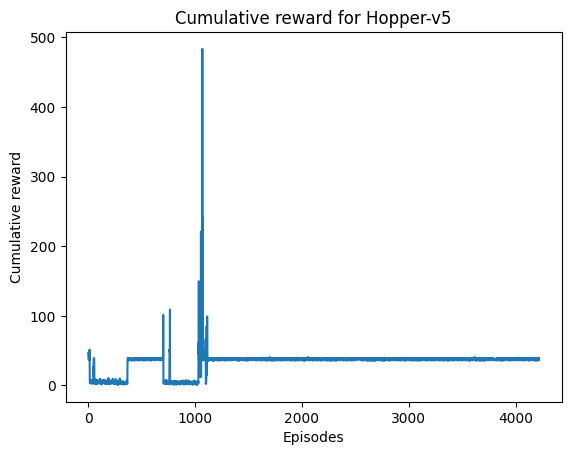

In [45]:
# main loop
def run_DDPG(env_type, mode):
    # initialize parameters
    params = {'actor_lr': 0.0001,
            'critic_lr': 0.001,
            'tau': 0.0001,
            'gamma': 0.99,
            'minibatch_size': 64,
            'replay_buffer_size': int(1e6),
            'steps': 100_000,
            'L2_weight_decay': 1e-2}

    # grab cwd for model saving
    cwd = os.getcwd()
    
    # create environment
    # env = gym.make(env_type, render_mode=mode)
    env = gym.make(env_type)

    # ddpg object
    ddpg = DDPGAgent(env, params, random_seed=10)

    # keep track of loss
    scores = []
    scores_deque = deque(maxlen=100)
    loss = []
    ep_count = 0
    step_count = 0

    # loop through desired number of steps
    while step_count < params['steps']:
        # reset env
        state,_ = env.reset()

        # initialize terminal state
        done = False
        truncate = False

        # track cumulative reward
        cumulative_reward = 0

        # while environment isnt terminal
        while not (done or truncate):
            # grab action with OU noise
            action = ddpg.get_action(env, state)
            # execute action in env
            next_state, reward, done, truncate, _ = env.step(action)
            # increment step
            step_count += 1
            
            # store in buffer
            ddpg.replay_buffer.insert(state, action, reward, next_state, done)

            # learn when buffer reaches batch size
            if len(ddpg.replay_buffer.buffer) > ddpg.batch_size:
                loss_item = ddpg.update()
                loss.append(loss_item)

            # update state
            state = next_state

            # update cumulative reward
            cumulative_reward += reward

        # add to ep count
        ep_count += 1

        # append to running score and to score deque for average reward approximation
        scores.append(cumulative_reward)
        scores_deque.append(cumulative_reward)
        print(f"\rStep {step_count}/{params['steps']} | Episode {ep_count} | "
          f"Average Score: {np.mean(scores_deque):.2f} | "
          f"Episode Score: {cumulative_reward:.2f}", end="", flush=True)
        # print('\rEpisode {}\tAverage Score: {:.2f}\tEpisode score: {:.2f}'.format(ep, np.mean(scores_deque), cumulative_reward), end="")
        # save scores
        if ep_count % 100 == 0:
            torch.save(ddpg.actor.state_dict(), f'{cwd}/checkpoint_{env_type}_actor.pth')
            torch.save(ddpg.critic.state_dict(), f'{cwd}/checkpoint_{env_type}_critic.pth')
            print('\rStep {} \tEpisode {}\tAverage Score: {:.2f}'.format(step_count, ep_count, np.mean(scores_deque)))   
        
        # reset env if done
        env.reset()

    # save scores and loss
    scores_df = pd.DataFrame({"Episode": np.arange(1, len(scores) + 1), "Scores": scores})
    loss_df = pd.DataFrame({"Step": np.arange(1, len(loss) + 1), "Loss": loss})

    scores_df.to_csv(f"{cwd}/results_{env_type}_scores.csv", index=False)
    loss_df.to_csv(f"{cwd}/results_{env_type}_loss.csv", index=False)
    
    return scores, loss

environments = ['Hopper-v5', 'HalfCheetah-v5', 'BipedalWalker-v3']

render_mode = ['human','human','human','human']

for i, env_type in enumerate(environments):
    scores, loss = run_DDPG(env_type, render_mode[i])

    plt.plot(np.arange(1,len(scores)+1), scores)
    plt.title(f"Cumulative reward for {env_type}")
    plt.ylabel('Cumulative reward')
    plt.xlabel('Episodes')
    plot_file = f"{os.getcwd()}/plot_{env_type}_scores.png"
    plt.savefig(plot_file)
    # plt.show()





In [ ]:
# grab cwd for model saving
cwd = os.getcwd()

# instantiate env
env = gym.make('Hopper-v5', render_mode='human')

# initialize parameters
params = {'actor_lr': 0.0001,
        'critic_lr': 0.001,
        'tau': 0.001,
        'gamma': 0.99,
        'minibatch_size': 64,
        'replay_buffer_size': int(10e6),
        'steps': 100_000}

ddpg = DDPGAgent(env, params, random_seed=10)

ddpg.actor.load_state_dict(torch.load(cwd+'/checkpoint_actor.pth'))
ddpg.critic.load_state_dict(torch.load(cwd+'/checkpoint_critic.pth'))

state,_ = env.reset()  
while True:
    action = ddpg.get_action(env, state)
    env.render()
    next_state, reward, done, truncate, _ = env.step(action)
    state = next_state
    if done:
        break
        
env.close()

Using cpu device
